## Final Project - Chicago Accidents Dataset

### 1.Acquire Data and Initial Exploration

In [1]:
## The ipython-sql library is loaded using the %load_ext iPython extension syntax and is pointed to the connection object 
%load_ext sql

In [94]:
## drop database in case it is already created. Ignore error "dbase_name does not exist"
!dropdb -U student dk

dropdb: database removal failed: ERROR:  database "GROUP15" does not exist


In [95]:
## create a new database for user student and nameit group15
!createdb -U student dk

In [2]:
## connect to the database. 
%sql postgresql://student@/dk

'Connected: student@dk'

In [97]:
## fetching the data from the s3 bucket that is wrangled
!wget https://gwu-workshop-verma-2019.s3.amazonaws.com/Traffic_Crashes.csv

--2019-12-01 03:27:38--  https://gwu-workshop-verma-2019.s3.amazonaws.com/Traffic_Crashes.csv
Resolving gwu-workshop-verma-2019.s3.amazonaws.com (gwu-workshop-verma-2019.s3.amazonaws.com)... 52.216.184.107
Connecting to gwu-workshop-verma-2019.s3.amazonaws.com (gwu-workshop-verma-2019.s3.amazonaws.com)|52.216.184.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97290092 (93M) [text/csv]
Saving to: ‘Traffic_Crashes.csv’

Traffic_Crashes.csv 100%[===================>]  92.78M  52.3MB/s    in 1.8s    

2019-12-01 03:27:40 (52.3 MB/s) - ‘Traffic_Crashes.csv’ saved [97290092/97290092]



In [98]:
!wget https://gwu-workshop-verma-2019.s3.amazonaws.com/weather_description.csv
#weather data file just to help us in the analysis

--2019-12-01 03:27:41--  https://gwu-workshop-verma-2019.s3.amazonaws.com/weather_description.csv
Resolving gwu-workshop-verma-2019.s3.amazonaws.com (gwu-workshop-verma-2019.s3.amazonaws.com)... 52.216.109.179
Connecting to gwu-workshop-verma-2019.s3.amazonaws.com (gwu-workshop-verma-2019.s3.amazonaws.com)|52.216.109.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1236130 (1.2M) [text/csv]
Saving to: ‘weather_description.csv’

weather_description 100%[===================>]   1.18M  --.-KB/s    in 0.03s   

2019-12-01 03:27:41 (46.5 MB/s) - ‘weather_description.csv’ saved [1236130/1236130]



In [99]:
## lets examine data, moving it first to more friendly file name
!mv Traffic_Crashes.csv chicago.csv

In [100]:
## check the number of lines in the file
!wc -l chicago.csv

363062 chicago.csv


In [101]:
## use csvcut to find the heading (attribute labels) of the file
!csvcut -n chicago.csv

  1: RD_NO
  2: CRASH_DATE
  3: POSTED_SPEED_LIMIT
  4: TRAFFIC_CONTROL_DEVICE
  5: DEVICE_CONDITION
  6: WEATHER_CONDITION
  7: LIGHTING_CONDITION
  8: ROADWAY_SURFACE_COND
  9: ROAD_DEFECT
 10: CRASH_TYPE
 11: INTERSECTION_RELATED_I
 12: HIT_AND_RUN_I
 13: DAMAGE
 14: DATE_POLICE_NOTIFIED
 15: PRIM_CONTRIBUTORY_CAUSE
 16: SEC_CONTRIBUTORY_CAUSE
 17: STREET_NO
 18: STREET_DIRECTION
 19: STREET_NAME
 20: BEAT_OF_OCCURRENCE
 21: NUM_UNITS
 22: INJURIES_TOTAL
 23: INJURIES_FATAL
 24: CRASH_HOUR
 25: CRASH_DAY_OF_WEEK
 26: CRASH_MONTH


In [102]:
## let's first have a feeling for the data values in the 4 fields
!head -n 5 chicago.csv

"RD_NO","CRASH_DATE","POSTED_SPEED_LIMIT","TRAFFIC_CONTROL_DEVICE","DEVICE_CONDITION","WEATHER_CONDITION","LIGHTING_CONDITION","ROADWAY_SURFACE_COND","ROAD_DEFECT","CRASH_TYPE","INTERSECTION_RELATED_I","HIT_AND_RUN_I","DAMAGE","DATE_POLICE_NOTIFIED","PRIM_CONTRIBUTORY_CAUSE","SEC_CONTRIBUTORY_CAUSE","STREET_NO","STREET_DIRECTION","STREET_NAME","BEAT_OF_OCCURRENCE","NUM_UNITS","INJURIES_TOTAL","INJURIES_FATAL","CRASH_HOUR","CRASH_DAY_OF_WEEK","CRASH_MONTH"
"JC334993","7/4/19 22:33","45","NO CONTROLS","NO CONTROLS","CLEAR","""DARKNESS, LIGHTED ROAD""","DRY","NO DEFECTS","NO INJURY / DRIVE AWAY","","","1500","7/4/19 23:05","FOLLOWING TOO CLOSELY","NOT APPLICABLE","300","N","LAKE SHORE DR SB","114","","","","22","5","7"
"JC370822","7/30/19 10:22","30","NO CONTROLS","NO CONTROLS","CLEAR","DAYLIGHT","DRY","NO DEFECTS","NO INJURY / DRIVE AWAY","","","1500","7/30/19 10:25","FAILING TO YIELD RIGHT-OF-WAY","IMPROPER TURNING/NO SIGNAL","8201","S","DR MARTIN LUTHER KING JR DR","631","","","","10",

In [107]:
## we won't be sure of our above conclusions on the data unless we examine a good sample of it. Let's do that for first 1% of the records
!head -n 500 chicago.csv | csvstat

  1. "RD_NO"

	Type of data:          Text
	Contains null values:  False
	Unique values:         499
	Longest value:         8 characters
	Most common values:    JC334993 (1x)
	                       JC370822 (1x)
	                       JC387098 (1x)
	                       JC395195 (1x)
	                       JC396604 (1x)

  2. "CRASH_DATE"

	Type of data:          DateTime
	Contains null values:  False
	Unique values:         421
	Smallest value:        2015-08-26 11:00:00
	Largest value:         2019-09-02 03:30:00
	Most common values:    2019-08-31 12:00:00 (5x)
	                       2019-08-30 18:30:00 (4x)
	                       2019-09-01 01:00:00 (4x)
	                       2019-08-30 16:45:00 (4x)
	                       2019-09-01 00:40:00 (3x)

  3. "POSTED_SPEED_LIMIT"

	Type of data:          Number
	Contains null values:  False
	Unique values:         11
	Smallest value:        0
	Largest value:         55
	Sum:                   14,195
	Mean:                  28.4

### 2.Build the Dimensional Model

In [108]:
from IPython.display import Image

In [109]:
Image(url="https://gwu-workshop-verma-2019.s3.amazonaws.com/Screen+Shot+2019-11-30+at+2.05.55+PM.png")

In [110]:
## create the initial table and load data into it

%%sql
DROP TABLE IF EXISTS accidents ;

create table accidents(
    RD_NO VARCHAR(10),
    CRASH_DATE timestamp,
    POSTED_SPEED_LIMIT numeric,
    TRAFFIC_CONTROL_DEVICE varchar(200),
    DEVICE_CONDITION varchar(200),
    WEATHER_CONDITION varchar(200),
    LIGHTING_CONDITION varchar(200),
    ROADWAY_SURFACE_COND varchar(200),
    ROAD_DEFECT varchar(200),
    CRASH_TYPE varchar(200),
    INTERSECTION_RELATED_I varchar(200),
    HIT_AND_RUN_I varchar(200),
    DAMAGE numeric,
    DATE_POLICE_NOTIFIED timestamp,
    PRIM_CONTRIBUTORY_CAUSE varchar(200),
    SEC_CONTRIBUTORY_CAUSE varchar(200),
    STREET_NO varchar(200),
    STREET_DIRECTION varchar(200),
    STREET_NAME varchar(200),
    BEAT_OF_OCCURRENCE varchar(200),
    NUM_UNITS varchar(200),
    INJURIES_TOTAL varchar(200),
    INJURIES_FATAL varchar(200),
    CRASH_HOUR varchar(200),
    CRASH_DAY_OF_WEEK varchar(200),
    CRASH_MONTH numeric
)

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.
Done.


[]

In [111]:
!pwd

/home/ubuntu/SQL/Week12


In [112]:
%%sql
COPY accidents FROM '/home/ubuntu/SQL/Week12/chicago.csv'
CSV
HEADER
;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
363061 rows affected.


[]

In [113]:
##check if the row count matches
%%sql
SELECT COUNT(*) FROM accidents;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
1 rows affected.


count
363061


In [114]:
!wc -l chicago.csv

363062 chicago.csv


In [115]:
##preview the initial table
%%sql
SELECT * FROM accidents
LIMIT 10

 * postgresql://student@/GROUP15
   postgresql://student@/dk
10 rows affected.


rd_no,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,roadway_surface_cond,road_defect,crash_type,intersection_related_i,hit_and_run_i,damage,date_police_notified,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,num_units,injuries_total,injuries_fatal,crash_hour,crash_day_of_week,crash_month
JC334993,2019-07-04 22:33:00,45,NO CONTROLS,NO CONTROLS,CLEAR,"""DARKNESS, LIGHTED ROAD""",DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,,,1500,2019-07-04 23:05:00,FOLLOWING TOO CLOSELY,NOT APPLICABLE,300,N,LAKE SHORE DR SB,114,,,,22,5,7
JC370822,2019-07-30 10:22:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,,,1500,2019-07-30 10:25:00,FAILING TO YIELD RIGHT-OF-WAY,IMPROPER TURNING/NO SIGNAL,8201,S,DR MARTIN LUTHER KING JR DR,631,,,,10,3,7
JC387098,2019-08-10 17:00:00,25,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,,,1000,2019-08-10 17:35:00,EQUIPMENT - VEHICLE CONDITION,NOT APPLICABLE,6747,S,CREGIER AVE,332,1,,,17,7,8
JC395195,2019-08-16 16:53:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,,Y,1000,2019-08-16 16:53:00,UNABLE TO DETERMINE,NOT APPLICABLE,554,N,FRANKLIN ST,1831,1,0,0,16,6,8
JC396604,2019-08-17 16:04:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,,Y,1000,2019-08-17 18:30:00,UNABLE TO DETERMINE,UNABLE TO DETERMINE,3700,N,WESTERN AVE,1921,1,0,0,16,7,8
JC411237,2019-08-28 19:20:00,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,DRY,UNKNOWN,NO INJURY / DRIVE AWAY,Y,,1500,2019-08-28 19:59:00,UNABLE TO DETERMINE,UNABLE TO DETERMINE,3716,S,ARCHER AVE,911,2,0,0,19,4,8
JC413474,2019-08-30 14:20:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,Y,,1500,2019-08-30 14:25:00,FAILING TO REDUCE SPEED TO AVOID CRASH,UNABLE TO DETERMINE,5335,S,WESTERN AVE,923,2,0,0,14,6,8
JC414382,2019-08-31 04:35:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"""DARKNESS, LIGHTED ROAD""",DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,,,1500,2019-08-31 04:35:00,PHYSICAL CONDITION OF DRIVER,NOT APPLICABLE,1501,N,HUMBOLDT DR,1423,1,1,0,4,7,8
JC413930,2019-08-30 18:30:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,,,1000,2019-08-30 19:57:00,FOLLOWING TOO CLOSELY,FOLLOWING TOO CLOSELY,5900,N,SHERIDAN RD,2022,2,0,0,18,6,8
JC415166,2019-08-31 18:50:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,,,1500,2019-08-31 19:02:00,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,UNABLE TO DETERMINE,5555,N,CLARK ST,2013,2,0,0,18,7,8


In [116]:
##build the weather dimension table

%%sql
SELECT DISTINCT weather_condition
FROM accidents
LIMIT 10;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
10 rows affected.


weather_condition
BLOWING SNOW
CLEAR
CLOUDY/OVERCAST
FOG/SMOKE/HAZE
FREEZING RAIN/DRIZZLE
OTHER
RAIN
SEVERE CROSS WIND GATE
SLEET/HAIL
SNOW


In [117]:
%%sql
DROP TABLE IF EXISTS weather;

CREATE TABLE weather (
    key SERIAL PRIMARY KEY,
    weather_condition varchar(200)
);

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.
Done.


[]

In [118]:
%%sql
INSERT INTO weather (weather_condition)
SELECT DISTINCT weather_condition
FROM accidents;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
11 rows affected.


[]

In [119]:
%%sql
SELECT * FROM weather;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
11 rows affected.


key,weather_condition
1,BLOWING SNOW
2,CLEAR
3,CLOUDY/OVERCAST
4,FOG/SMOKE/HAZE
5,FREEZING RAIN/DRIZZLE
6,OTHER
7,RAIN
8,SEVERE CROSS WIND GATE
9,SLEET/HAIL
10,SNOW


In [120]:
##build the lighting dimension table

%%sql
SELECT DISTINCT lighting_condition
FROM accidents
LIMIT 10;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
6 rows affected.


lighting_condition
DARKNESS
"""DARKNESS, LIGHTED ROAD"""
DAWN
DAYLIGHT
DUSK
UNKNOWN


In [121]:
%%sql
DROP TABLE IF EXISTS lighting;

CREATE TABLE lighting (
    key SERIAL PRIMARY KEY,
    lighting_condition varchar(200)
);

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.
Done.


[]

In [122]:
%%sql
INSERT INTO lighting (lighting_condition)
SELECT DISTINCT lighting_condition
FROM accidents;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
6 rows affected.


[]

In [123]:
%%sql
SELECT * FROM lighting;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
6 rows affected.


key,lighting_condition
1,DARKNESS
2,"""DARKNESS, LIGHTED ROAD"""
3,DAWN
4,DAYLIGHT
5,DUSK
6,UNKNOWN


In [124]:
%%sql
ALTER TABLE accidents
ADD COLUMN weather_key INTEGER,
ADD CONSTRAINT fk_weather_key
    FOREIGN KEY (weather_key)
    REFERENCES weather (key);

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.


[]

In [125]:
%%sql
ALTER TABLE accidents
ADD COLUMN lighting_key INTEGER,
ADD CONSTRAINT fk_lighting_key
    FOREIGN KEY (lighting_key)
    REFERENCES lighting (key);

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.


[]

In [126]:
##build the traffic device dimension table

%%sql
DROP TABLE IF EXISTS traffic_device;

CREATE TABLE traffic_device (
    key SERIAL PRIMARY KEY,
    TRAFFIC_CONTROL_DEVICE varchar(200)
);

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.
Done.


[]

In [127]:
%%sql
INSERT INTO traffic_device (TRAFFIC_CONTROL_DEVICE)
SELECT DISTINCT TRAFFIC_CONTROL_DEVICE
FROM accidents;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
18 rows affected.


[]

In [128]:
%%sql
ALTER TABLE accidents
ADD COLUMN TRAFFIC_CONTROL_DEVICE_key INTEGER,
ADD CONSTRAINT fk_TRAFFIC_CONTROL_DEVICE_key
    FOREIGN KEY (TRAFFIC_CONTROL_DEVICE_key)
    REFERENCES traffic_device (key);

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.


[]

In [129]:
##build the device condition dimension table

%%sql
DROP TABLE IF EXISTS device_condition;

CREATE TABLE device_condition (
    key SERIAL PRIMARY KEY,
    DEVICE_CONDITION varchar(200)
);

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.
Done.


[]

In [130]:
%%sql
INSERT INTO device_condition (device_condition)
SELECT DISTINCT device_condition
FROM accidents;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
7 rows affected.


[]

In [131]:
%%sql
ALTER TABLE accidents
ADD COLUMN device_condition_key INTEGER,
ADD CONSTRAINT device_condition_key
    FOREIGN KEY (device_condition_key)
    REFERENCES device_condition (key);

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.


[]

In [132]:
%%sql
SELECT DISTINCT ROAD_DEFECT, ROADWAY_SURFACE_COND
FROM accidents
LIMIT 10;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
10 rows affected.


road_defect,roadway_surface_cond
DEBRIS ON ROADWAY,DRY
DEBRIS ON ROADWAY,ICE
DEBRIS ON ROADWAY,OTHER
DEBRIS ON ROADWAY,"""SAND, MUD, DIRT"""
DEBRIS ON ROADWAY,SNOW OR SLUSH
DEBRIS ON ROADWAY,UNKNOWN
DEBRIS ON ROADWAY,WET
NO DEFECTS,DRY
NO DEFECTS,ICE
NO DEFECTS,OTHER


In [133]:
##build the road_condition dimension table

%%sql
DROP TABLE IF EXISTS road_condition;

CREATE TABLE road_condition (
    key SERIAL PRIMARY KEY,
    road_defect VARCHAR(200),
    roadway_surface_cond VARCHAR(200)
);

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.
Done.


[]

In [134]:
%%sql
INSERT INTO road_condition (road_defect, roadway_surface_cond)
SELECT DISTINCT ROAD_DEFECT, ROADWAY_SURFACE_COND
FROM accidents;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
41 rows affected.


[]

In [135]:
%%sql
ALTER TABLE accidents
ADD COLUMN road_condition_key INTEGER,
ADD CONSTRAINT fk_road_condition
    FOREIGN KEY (road_condition_key)
    REFERENCES road_condition (key);

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.


[]

In [136]:
##build the location dimension table

%%sql
DROP TABLE IF EXISTS location;

CREATE TABLE location (
    key SERIAL PRIMARY KEY,
    STREET_NO varchar(200),
    STREET_DIRECTION varchar(200),
    STREET_NAME varchar(200),
    BEAT_OF_OCCURRENCE varchar(200)
);

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.
Done.


[]

In [137]:
%%sql
INSERT INTO location (STREET_NO, STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE)
SELECT DISTINCT STREET_NO, STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE
FROM accidents;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
180708 rows affected.


[]

In [138]:
%%sql
ALTER TABLE accidents
ADD COLUMN location_key INTEGER,
ADD CONSTRAINT fk_location
    FOREIGN KEY (location_key)
    REFERENCES location (key);

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.


[]

In [139]:
##build the crash dump dimension table

%%sql
DROP TABLE IF EXISTS crash_dump;

CREATE TABLE crash_dump (
    key SERIAL PRIMARY KEY,
    CRASH_TYPE varchar(200),
    HIT_AND_RUN_I varchar(200),
    INTERSECTION_RELATED_I varchar(200),
    PRIM_CONTRIBUTORY_CAUSE varchar(200),
    SEC_CONTRIBUTORY_CAUSE varchar(200),
    POSTED_SPEED_LIMIT numeric
);

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.
Done.


[]

In [140]:
%%sql
INSERT INTO crash_dump (CRASH_TYPE, HIT_AND_RUN_I,INTERSECTION_RELATED_I,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,POSTED_SPEED_LIMIT)
SELECT DISTINCT CRASH_TYPE, HIT_AND_RUN_I,INTERSECTION_RELATED_I,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,POSTED_SPEED_LIMIT
FROM accidents;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
15698 rows affected.


[]

In [141]:
%%sql
ALTER TABLE accidents
ADD COLUMN crash_dump_key INTEGER,
ADD CONSTRAINT fk_crash_dump
    FOREIGN KEY (crash_dump_key)
    REFERENCES crash_dump (key);

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.


[]

In [142]:
##build the day dimension table

%%sql
DROP TABLE IF EXISTS day;

CREATE TABLE day (
    key SERIAL PRIMARY KEY,
    RD_NO VARCHAR(10),
    CRASH_DATE timestamp,
    DATE_POLICE_NOTIFIED timestamp,
    CRASH_HOUR varchar(200),
    CRASH_DAY_OF_WEEK varchar(200),
    CRASH_MONTH numeric
);

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.
Done.


[]

In [143]:
%%sql
INSERT INTO day (RD_NO, CRASH_DATE,DATE_POLICE_NOTIFIED,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH)
SELECT DISTINCT RD_NO, CRASH_DATE,DATE_POLICE_NOTIFIED,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH
FROM accidents;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
363061 rows affected.


[]

In [144]:
%%sql
ALTER TABLE accidents
ADD COLUMN day_key INTEGER,
ADD CONSTRAINT day
    FOREIGN KEY (day_key)
    REFERENCES day (key);

 * postgresql://student@/GROUP15
   postgresql://student@/dk
Done.


[]

In [ ]:
##The following 8 blocks populate new columns in initial table with foreign keys to the corresponding dimension table.

In [145]:
%%sql
UPDATE accidents
SET device_condition_key = device_condition.key
FROM device_condition
WHERE accidents.device_condition = device_condition.device_condition;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
363061 rows affected.


[]

In [146]:
%%sql
UPDATE accidents
SET lighting_key = lighting.key
FROM lighting
WHERE accidents.LIGHTING_CONDITION = lighting.LIGHTING_CONDITION;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
363061 rows affected.


[]

In [147]:
%%sql
UPDATE accidents
SET TRAFFIC_CONTROL_DEVICE_key = traffic_device.key
FROM traffic_device
WHERE accidents.TRAFFIC_CONTROL_DEVICE = traffic_device.TRAFFIC_CONTROL_DEVICE;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
363061 rows affected.


[]

In [148]:
%%sql
UPDATE accidents
SET road_condition_key = road_condition.key
FROM road_condition
WHERE accidents.ROAD_DEFECT = road_condition.ROAD_DEFECT AND accidents.ROADWAY_SURFACE_COND = road_condition.ROADWAY_SURFACE_COND ;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
363061 rows affected.


[]

In [149]:
%%sql
UPDATE accidents
SET weather_key = weather.key
FROM weather
WHERE accidents.WEATHER_CONDITION = weather.WEATHER_CONDITION ;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
363061 rows affected.


[]

In [150]:
%%sql
UPDATE accidents
SET location_key = location.key
FROM location
WHERE accidents.STREET_NO = location.STREET_NO AND accidents.STREET_DIRECTION = location.STREET_DIRECTION AND
accidents.STREET_NAME = location.STREET_NAME AND accidents.BEAT_OF_OCCURRENCE = location.BEAT_OF_OCCURRENCE;

 * postgresql://student@/GROUP15
   postgresql://student@/dk
363061 rows affected.


[]

In [ ]:
%%sql
UPDATE accidents
SET crash_dump_key = crash_dump.key
FROM crash_dump
WHERE accidents.CRASH_TYPE = crash_dump.CRASH_TYPE AND accidents.HIT_AND_RUN_I = crash_dump.HIT_AND_RUN_I AND
accidents.INTERSECTION_RELATED_I = crash_dump.INTERSECTION_RELATED_I AND accidents.PRIM_CONTRIBUTORY_CAUSE = crash_dump.PRIM_CONTRIBUTORY_CAUSE AND
accidents.SEC_CONTRIBUTORY_CAUSE = crash_dump.SEC_CONTRIBUTORY_CAUSE AND accidents.POSTED_SPEED_LIMIT = crash_dump.POSTED_SPEED_LIMIT;

 * postgresql://student@/GROUP15


In [ ]:
%%sql
UPDATE accidents
SET day_key = day.key
FROM day
WHERE accidents.CRASH_DATE = day.CRASH_DATE AND accidents.CRASH_HOUR = day.CRASH_HOUR AND
accidents.CRASH_MONTH = day.CRASH_MONTH AND accidents.CRASH_DAY_OF_WEEK = day.CRASH_DAY_OF_WEEK AND
accidents.DATE_POLICE_NOTIFIED = day.DATE_POLICE_NOTIFIED AND accidents.RD_NO = day.RD_NO;

In [ ]:
##drop the old columns in initial table and finish it as fact table

%%sql
ALTER TABLE accidents
DROP COLUMN DEVICE_CONDITION,
DROP COLUMN LIGHTING_CONDITION,
DROP COLUMN TRAFFIC_CONTROL_DEVICE,
DROP COLUMN WEATHER_CONDITION,
DROP COLUMN ROAD_DEFECT,
DROP COLUMN ROADWAY_SURFACE_COND,
DROP COLUMN STREET_NO,
DROP COLUMN STREET_DIRECTION,
DROP COLUMN STREET_NAME,
DROP COLUMN BEAT_OF_OCCURRENCE,
DROP COLUMN CRASH_TYPE,
DROP COLUMN HIT_AND_RUN_I,
DROP COLUMN INTERSECTION_RELATED_I,
DROP COLUMN PRIM_CONTRIBUTORY_CAUSE,
DROP COLUMN SEC_CONTRIBUTORY_CAUSE,
DROP COLUMN POSTED_SPEED_LIMIT,
DROP COLUMN CRASH_DATE,
DROP COLUMN CRASH_HOUR,
DROP COLUMN CRASH_MONTH,
DROP COLUMN CRASH_DAY_OF_WEEK,
DROP COLUMN DATE_POLICE_NOTIFIED,
DROP COLUMN RD_NO
;

In [ ]:
#final look at the facts table

In [3]:
%%sql
select * from accidents
limit 5;

 * postgresql://student@/dk
5 rows affected.


damage,num_units,injuries_total,injuries_fatal,weather_key,lighting_key,traffic_control_device_key,device_condition_key,road_condition_key,location_key,crash_dump_key,day_key
1000,2,0,0,3,5,5,4,35,53620,8498,67735
1500,2,0,0,2,4,5,4,8,53618,11125,97222
1000,1,0,0,2,4,5,4,8,53615,9834,316870
500,2,0,0,2,4,15,2,8,53612,8694,145421
1000,2,0,0,2,4,16,2,8,53613,9884,196619


#### ---- A few basic results from the dataset

In [4]:
# number of units involved in an accident

In [5]:
%%sql
select num_units,count(*) from accidents
group by num_units
order by count(*) desc;


 * postgresql://student@/dk
15 rows affected.


num_units,count
2,320946
1,19457
3,17370
4,3000
,1305
5,688
6,177
7,69
8,25
9,10


In [6]:
#majority of accidents involve 2 cars

<BarContainer object of 15 artists>

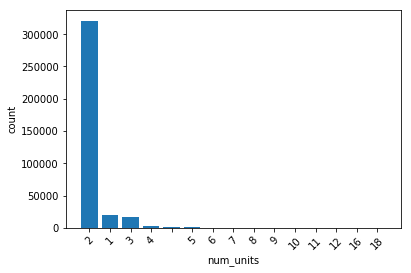

In [7]:
%matplotlib inline
_.bar()

In [8]:
#number of crashes according to week days 

In [9]:
%%sql
select crash_day_of_week,count(*) from day
group by crash_day_of_week
order by count(*) desc


 * postgresql://student@/dk
7 rows affected.


crash_day_of_week,count
6,58752
7,52950
3,52829
5,52389
4,52056
2,50810
1,43275


In [10]:
#number of crashes peak on friday
#day 1 is sunday 

In [11]:
#we can take measures in friday i.e., weekend beinning to reduce the number of accidents

<BarContainer object of 7 artists>

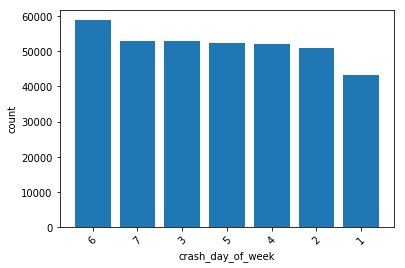

In [12]:
%matplotlib inline
_.bar()

In [13]:
#number of crashes on different months of the year

In [14]:
%%sql
select crash_month,count(*) from day
group by crash_month
order by crash_month;

 * postgresql://student@/dk
12 rows affected.


crash_month,count
1,25742
2,23952
3,27016
4,26942
5,30262
6,30254
7,30982
8,32641
9,34949
10,38028


In [15]:
#october has he most accidents

<BarContainer object of 12 artists>

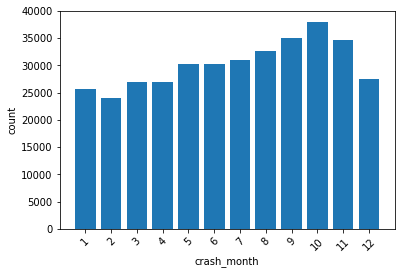

In [16]:
%matplotlib inline
_.bar()

In [17]:
#equivalent command as we have all the rows in the day table beacuse our primary key rd_no is there we get the same result

In [18]:
%%sql
select day.crash_month, count(*)
from day, accidents
where day.key = accidents.day_key
group by crash_month
order by crash_month

 * postgresql://student@/dk
12 rows affected.


crash_month,count
1,25742
2,23952
3,27016
4,26942
5,30262
6,30254
7,30982
8,32641
9,34949
10,38028


In [19]:
## find the crash counts by location 
## that is relsted to location
## just to add on this we can find average accidents , average accidents by location and compare to find of a location has higher number of accidents.

## later we can investigate that location for traffic device and device condition in that location.
## we can do this for one location . 

### Q1. Crash Counts by Location with Furthur Exploration

##### Ranking locations by number of accidents

In [20]:
%%sql
select street_name,street_direction,street_no,count(*)
from(
select location.street_name,location.street_direction,location.street_no,accidents.location_key
from accidents, location
where location.key=accidents.location_key) as t
group by street_name,street_direction,street_no
order by count(*) desc
limit 20

 * postgresql://student@/dk
20 rows affected.


street_name,street_direction,street_no,count
OHARE ST,W,10000,443
LAKE SHORE DR,S,5700,230
STONY ISLAND AVE,S,7900,229
STONY ISLAND AVE,S,9500,199
CICERO AVE,S,7601,183
CICERO AVE,S,5700,182
LAKE SHORE DR SB,N,1000,137
STEWART AVE,S,8331,134
87TH ST,W,112,131
CICERO AVE,S,5500,128


In [21]:
#from above, we can find that OHARE ST	W	10000 has a larger number than all other location,
#we can look into the geometry of the streets the deivce condition or other factors, thereby finding the right reason and working on it will reduce the accidents

In [22]:
from IPython.display import Image

In [23]:
Image(url='https://gwu-workshop-verma-2019.s3.amazonaws.com/Screen+Shot+2019-11-27+at+7.07.55+PM.png')

In [24]:
%%sql
select * from(
select n.beat_of_occurrence,n.street_name,n.street_direction,n.street_no,count(*), SUM(count(*)) over(Partition BY n.beat_of_occurrence) as total,rank()
over(Partition BY n.beat_of_occurrence ORDER BY count(*) DESC) as rank
    
from(
select beat_of_occurrence,street_name,street_direction,street_no,key,location_key
from accidents, location
where location.key=accidents.location_key
) as n
    
group by n.beat_of_occurrence,n.street_name,n.street_direction,n.street_no
) as m
where rank<6
order by total desc
limit 50;

 * postgresql://student@/dk
50 rows affected.


beat_of_occurrence,street_name,street_direction,street_no,count,total,rank
1834,GRAND AVE,E,600,125,5353,1
1834,MICHIGAN AVE,N,600,82,5353,2
1834,MICHIGAN AVE,N,500,44,5353,4
1834,LAKE SHORE DR NB,N,500,42,5353,5
1834,LAKE SHORE DR,N,500,59,5353,3
114,LAKE SHORE DR SB,S,100,78,4353,2
114,CONGRESS DR,E,100,49,4353,5
114,LAKE SHORE DR NB,S,100,49,4353,5
114,LAKE SHORE DR E,S,700,52,4353,4
114,LAKE SHORE DR SB,S,300,53,4353,3


In [ ]:
#ranked for 5 locations based on total division on locations available

In [25]:
# same as above but we have the beat of occurance also included that makes the detection of location easier
#also adding each location under that by rank i.e., restricted to top 6

In [26]:
#so the top 3 beats are 1834,114 and 112

##### Top 3 beats with device condition analysis

In [27]:
%%sql
select beat_of_occurrence,device_condition,percentage
from(
select beat_of_occurrence,device_condition,count(*),cast(count(*)/(sum(count(*)) over(Partition BY beat_of_occurrence)) as decimal(10,2)) as percentage  
from(
select * 
from(
select accidents.*,location.*,device_condition.*
from accidents,location,device_condition
where accidents.location_key=location.key and accidents.device_condition_key=device_condition.key
) as t
where beat_of_occurrence='1834' or beat_of_occurrence='114' or beat_of_occurrence='122'
) as t1
group by beat_of_occurrence,device_condition
order by beat_of_occurrence, count(*) desc) as t2
where percentage>0


 * postgresql://student@/dk
11 rows affected.


beat_of_occurrence,device_condition,percentage
114,FUNCTIONING PROPERLY,0.51
114,NO CONTROLS,0.43
114,UNKNOWN,0.05
114,FUNCTIONING IMPROPERLY,0.01
122,FUNCTIONING PROPERLY,0.48
122,NO CONTROLS,0.45
122,UNKNOWN,0.05
1834,NO CONTROLS,0.52
1834,FUNCTIONING PROPERLY,0.42
1834,UNKNOWN,0.05


In [ ]:
#percentage of device condiotion based on the top 3 beat values fir accidents

<BarContainer object of 11 artists>

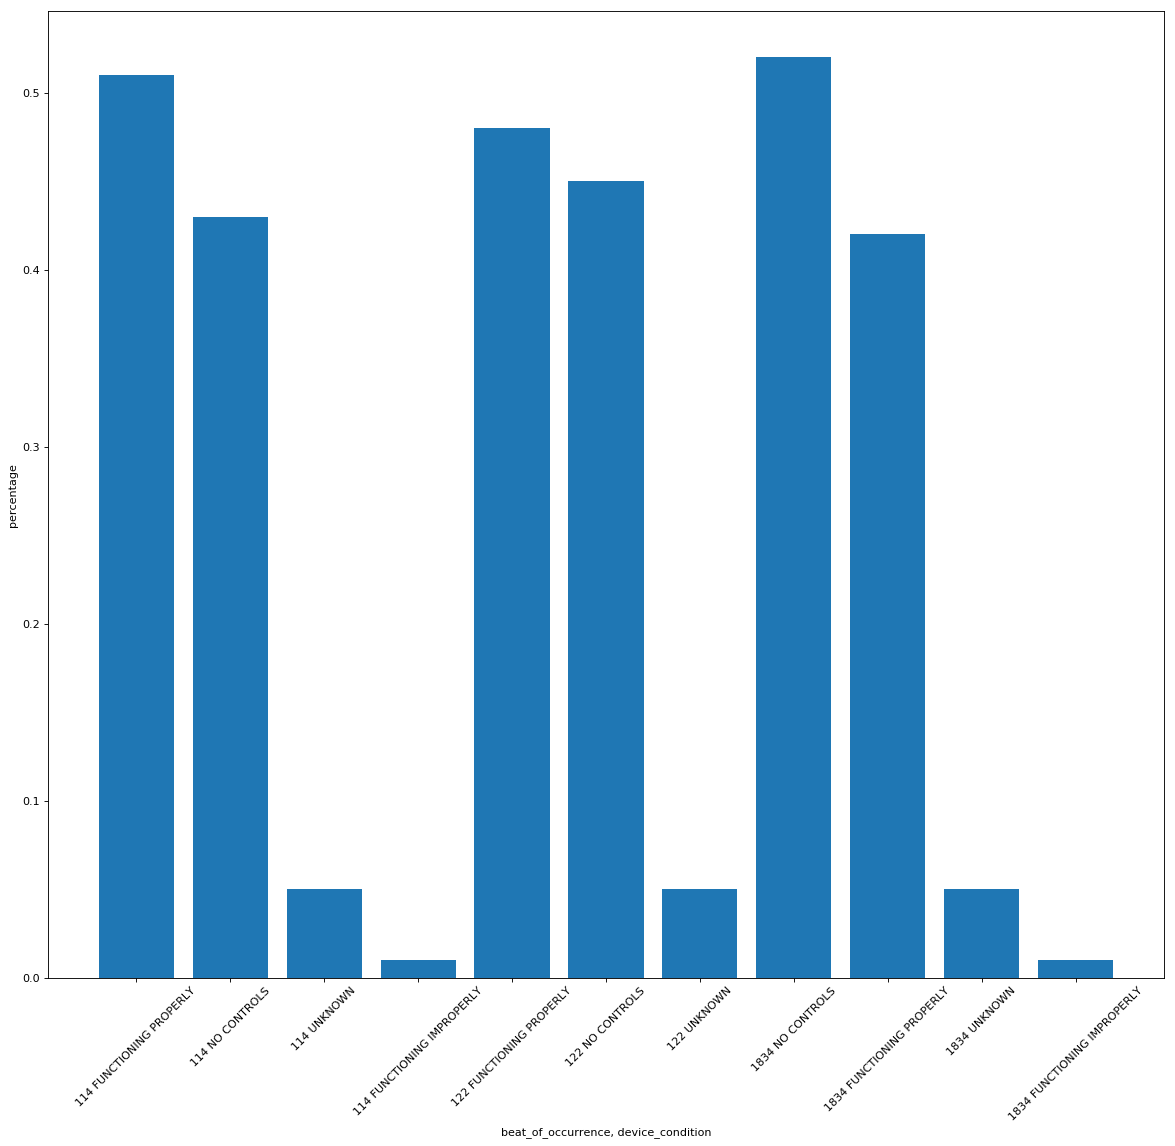

In [28]:
import matplotlib as plt
%matplotlib inline
fig=plt.pyplot.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
_.bar()

In [29]:
#top three beat_of_occurence vs traffic device.

In [30]:
%%sql
select * from (
select beat_of_occurrence,traffic_control_device,cast(count(*)/(sum(count(*)) over(Partition BY beat_of_occurrence)) as decimal(10,2)) as percentage
from(
select * 
from(
select accidents.*,location.*,traffic_device.*
from accidents,location,traffic_device
where accidents.location_key=location.key and accidents.traffic_control_device_key=traffic_device.key
) as t
where beat_of_occurrence='1834' or beat_of_occurrence='114' or beat_of_occurrence='122'
) as t1

group by beat_of_occurrence,traffic_control_device
order by beat_of_occurrence, count(*) desc) as t2
where percentage>0

 * postgresql://student@/dk
14 rows affected.


beat_of_occurrence,traffic_control_device,percentage
114,TRAFFIC SIGNAL,0.50
114,NO CONTROLS,0.43
114,STOP SIGN/FLASHER,0.03
114,UNKNOWN,0.03
114,LANE USE MARKING,0.01
122,TRAFFIC SIGNAL,0.49
122,NO CONTROLS,0.45
122,UNKNOWN,0.03
122,STOP SIGN/FLASHER,0.02
1834,NO CONTROLS,0.52


In [31]:
#top three beat_of_occurence vs road defect and later road surface condition

In [32]:
%%sql
select beat_of_occurrence,road_defect,count(*)
from(
select * 
from(
select accidents.*,location.*,road_condition.*
from accidents,location,road_condition
where accidents.location_key=location.key and accidents.road_condition_key=road_condition.key
) as t
where beat_of_occurrence='1834' or beat_of_occurrence='114' or beat_of_occurrence='122'
) as t1
group by beat_of_occurrence,road_defect
order by beat_of_occurrence, count(*) desc

 * postgresql://student@/dk
18 rows affected.


beat_of_occurrence,road_defect,count
114,NO DEFECTS,3679
114,UNKNOWN,537
114,"""RUT, HOLES""",96
114,WORN SURFACE,31
114,SHOULDER DEFECT,7
114,DEBRIS ON ROADWAY,3
122,NO DEFECTS,3703
122,UNKNOWN,558
122,WORN SURFACE,21
122,"""RUT, HOLES""",12


In [33]:
#adding a bit more depth to this

In [34]:
%%sql
select * from (
select beat_of_occurrence,road_defect,roadway_surface_cond,cast(count(*)/(sum(count(*)) over(Partition BY beat_of_occurrence)) as decimal(10,2)) as percentage
from(
select * 
from(
select accidents.*,location.*,road_condition.*
from accidents,location,road_condition
where accidents.location_key=location.key and accidents.road_condition_key=road_condition.key
) as t
where beat_of_occurrence='1834' or beat_of_occurrence='114' or beat_of_occurrence='122'
) as t1
group by beat_of_occurrence,road_defect,roadway_surface_cond
order by beat_of_occurrence, count(*) desc) as t2
where percentage>0

 * postgresql://student@/dk
25 rows affected.


beat_of_occurrence,road_defect,roadway_surface_cond,percentage
114,NO DEFECTS,DRY,0.71
114,NO DEFECTS,WET,0.11
114,UNKNOWN,DRY,0.06
114,UNKNOWN,UNKNOWN,0.05
114,UNKNOWN,WET,0.02
114,NO DEFECTS,SNOW OR SLUSH,0.01
114,"""RUT, HOLES""",DRY,0.01
114,WORN SURFACE,DRY,0.01
114,"""RUT, HOLES""",WET,0.01
114,NO DEFECTS,UNKNOWN,0.01


<BarContainer object of 25 artists>

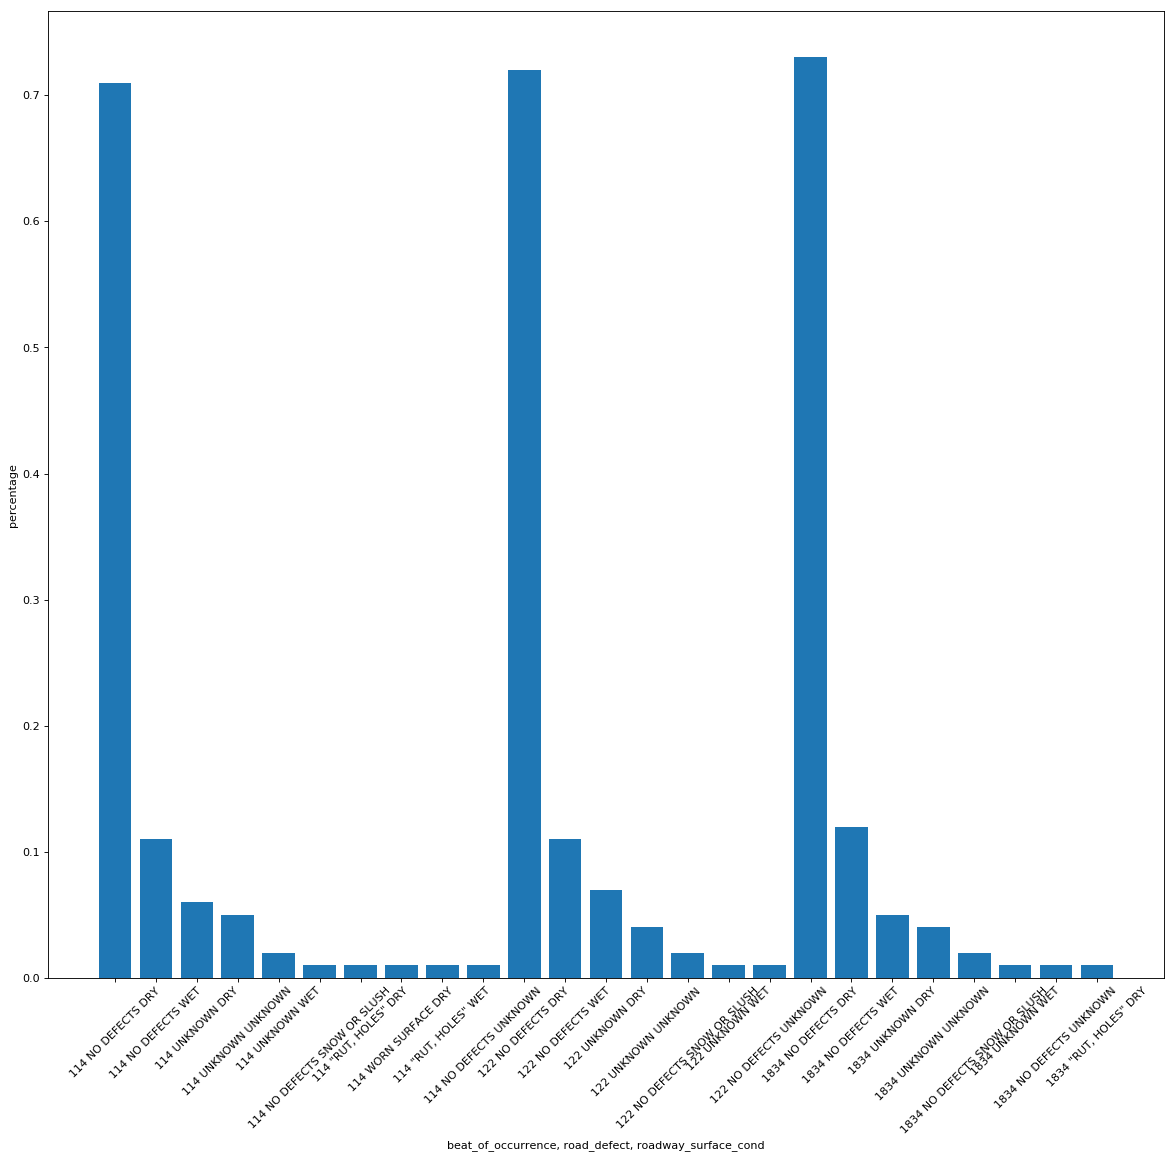

In [35]:
import matplotlib as plt
%matplotlib inline
fig=plt.pyplot.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
_.bar()

##### List of the top most dangerous streets

In [36]:
%%sql
select street_name,count(*)
from(
select accidents.*, location.street_name
from accidents, location
where location.key=accidents.location_key) as t
group by street_name
order by count(*) desc
limit 10

 * postgresql://student@/dk
10 rows affected.


street_name,count
WESTERN AVE,9902
PULASKI RD,8630
CICERO AVE,7844
ASHLAND AVE,7789
HALSTED ST,6875
KEDZIE AVE,6111
MICHIGAN AVE,5217
STATE ST,4553
CLARK ST,4408
NORTH AVE,4361


##### The relationship of the time between police notified time and crash occur time and injury situation. 

In [37]:
%%sql
select t2.inj_num,avg(t2.time_interval) as average_time
from(
select * from (
select inj_num,DATE_PART('hour', date_police_notified::time - crash_date::time) * 60 +
              DATE_PART('minute', date_police_notified::time - crash_date::time) as time_interval 
from(
select CASE
    WHEN injuries_total in ('0') THEN
         'nobody injured'
    WHEN injuries_total in ('1','2','3','4','5') THEN
         '<=5'
    WHEN injuries_total in ('6','7','8','9','10') THEN
         '<=10'
    WHEN injuries_total in ('10','11','13','15','16','21') THEN
         '>10'
    ELSE
         'unknown'
    END AS inj_num,day.crash_date,day.date_police_notified
from accidents, day
where day.key=accidents.day_key) as t) as t1
where time_interval>0 and time_interval<1000) as t2
group by inj_num
order by average_time

 * postgresql://student@/dk
5 rows affected.


inj_num,average_time
>10,4.71428571428571
<=10,15.2230215827338
<=5,40.2794329096451
unknown,81.6551094890511
nobody injured,98.7588434570236


<BarContainer object of 5 artists>

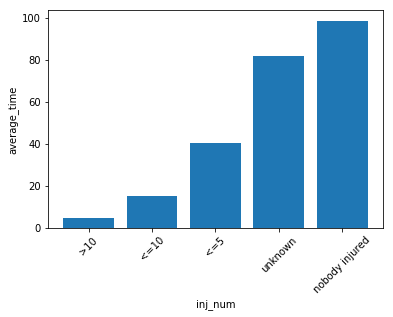

In [38]:
%matplotlib inline
_.bar()

In [39]:
#from this we can find, after we ingore the outliers(such as negative time interval where the entered values are wrong and time interval larger than 3600 minutes), more people get hurt in a traffic crash, more quickly police react totally

In [40]:
%%sql
CREATE or replace VIEW time AS
select date_police_notified - crash_date as time_interval , 
accidents.injuries_total,day.crash_date,day.date_police_notified,location.BEAT_OF_OCCURRENCE
from accidents,day,location
where day.key=accidents.day_key and location.key = accidents.location_key


 * postgresql://student@/dk
Done.


[]

In [41]:
%%sql
select avg(time_interval) from time;

 * postgresql://student@/dk
1 rows affected.


avg
16:02:49.558283


In [42]:
%%sql
select avg(time_interval),BEAT_OF_OCCURRENCE
from time
group by BEAT_OF_OCCURRENCE
order by avg desc
limit 10;

 * postgresql://student@/dk
10 rows affected.


avg,beat_of_occurrence
"1 day, 20:25:52.558139",1712
"1 day, 17:23:49.562088",1031
"1 day, 15:27:27.333333",432
"1 day, 11:07:44.601770",2534
"1 day, 10:14:28.243243",121
"1 day, 9:23:23.044620",1121
"1 day, 9:11:22.909091",531
"1 day, 8:17:27.327859",1631
"1 day, 7:48:35.249205",334
"1 day, 7:32:52.192903",1932


In [43]:
%%sql
select  
DATE_PART('day', date_police_notified::time - crash_date::time) as days , 
DATE_PART('hour', date_police_notified::time - crash_date::time) as hours ,
DATE_PART('minute', date_police_notified::time - crash_date::time) as minutes , accidents.injuries_total,day.crash_date,day.date_police_notified
from accidents,day
where day.key=accidents.day_key 
limit 10;

 * postgresql://student@/dk
10 rows affected.


days,hours,minutes,injuries_total,crash_date,date_police_notified
0.0,0.0,10.0,0,2017-03-31 17:50:00,2017-03-31 18:00:00
0.0,0.0,22.0,0,2017-08-23 17:45:00,2017-08-23 18:07:00
0.0,0.0,3.0,0,2019-07-09 10:30:00,2019-07-09 10:33:00
0.0,2.0,6.0,0,2018-01-24 13:50:00,2018-01-24 15:56:00
0.0,0.0,28.0,0,2018-07-02 13:50:00,2018-07-02 14:18:00
0.0,0.0,8.0,0,2018-08-05 13:39:00,2018-08-05 13:47:00
0.0,0.0,5.0,0,2018-09-03 08:00:00,2018-09-03 08:05:00
0.0,0.0,50.0,0,2019-02-06 16:00:00,2019-02-06 16:50:00
0.0,0.0,11.0,3,2018-07-08 20:57:00,2018-07-08 21:08:00
0.0,0.0,11.0,0,2019-02-02 12:00:00,2019-02-02 12:11:00


### Q2. Relationship Between the Device Condition, Damage and Number of Crash.

##### Eg. if the device is not functioning normally, we might have more damage and more crashes. 

In [44]:
%%sql
select traffic_control_device,device_condition,count(*)
from(
select device_condition.device_condition,traffic_device.traffic_control_device,damage
from device_condition,traffic_device,accidents
where device_condition.key=accidents.device_condition_key and traffic_device.key=accidents.traffic_control_device_key
) as t
group by traffic_control_device,device_condition
order by count(*) desc
limit 10

 * postgresql://student@/dk
10 rows affected.


traffic_control_device,device_condition,count
NO CONTROLS,NO CONTROLS,203749
TRAFFIC SIGNAL,FUNCTIONING PROPERLY,93329
STOP SIGN/FLASHER,FUNCTIONING PROPERLY,28310
UNKNOWN,UNKNOWN,12102
TRAFFIC SIGNAL,UNKNOWN,4439
STOP SIGN/FLASHER,NO CONTROLS,4141
NO CONTROLS,UNKNOWN,3115
STOP SIGN/FLASHER,UNKNOWN,2215
TRAFFIC SIGNAL,NO CONTROLS,1684
NO CONTROLS,FUNCTIONING PROPERLY,1600


In [45]:
#most of crash occur in no traffic control situation, so government should pay more attention on these area, it will hugely impact the accident situation

##### Relationship between the device condition and damage 

##### Considering the situation when the device condition of the traffic signal is not proper

In [46]:
%%sql
select damage,count(*)
from(
select device_condition, damage
from (
select device_condition.device_condition,traffic_device.traffic_control_device,damage
from device_condition,traffic_device,accidents
where device_condition.key=accidents.device_condition_key and traffic_device.key=accidents.traffic_control_device_key
) as t
where device_condition='FUNCTIONING IMPROPERLY' and traffic_control_device='TRAFFIC SIGNAL') as t1
group by damage;

 * postgresql://student@/dk
3 rows affected.


damage,count
500,186
1000,343
1500,801


(-1.110071587730638, 1.113526007286741, -1.1130096406560681, 1.100619506697908)

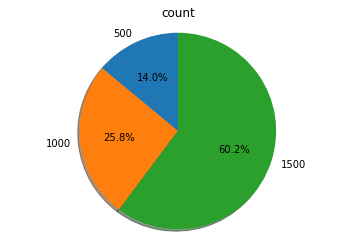

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
_.pie(autopct='%1.1f%%',
        shadow=True,startangle=90) 
plt.axis('equal')

In [48]:
#Above is the propotion of traffic signal running improperly 
#we observe that the we have accidents with major impacts and high costs when the device condition of traffic lights is malfunctioning, we can tell them to account for working towards proper functioning of devices.

#### Accidents associated with the no control area of the city account for higher costs

In [49]:
%%sql
select damage,count(*)
from(
select device_condition, damage
from (
select device_condition.device_condition,traffic_device.traffic_control_device,damage
from device_condition,traffic_device,accidents
where device_condition.key=accidents.device_condition_key and traffic_device.key=accidents.traffic_control_device_key
) as t
where device_condition='NO CONTROLS' and traffic_control_device='NO CONTROLS') as t1
group by damage

 * postgresql://student@/dk
3 rows affected.


damage,count
500,27311
1000,64837
1500,111601


In [50]:
#from above we can see that there are most number of accidents where we have no traffic signals and no control over the traffic 
#we showld look for this issue deeper and try to fix this, starting from the more prone areas 

### Q3. Weather Effects on Crashes

##### Using an external weather data file for this that is based on chicago data

In [51]:
%%sql
select weather_condition,count 
from(
select weather_condition,count(*)
from(
select *
from(
select accidents.*,crash_date,weather_condition
from accidents,day,weather
where day.key=accidents.day_key and weather.key=accidents.weather_key) as t
where crash_date between '2016-01-01' and '2017-12-31') as t1
group by weather_condition) as t2
where weather_condition='SNOW' or weather_condition='RAIN'
or weather_condition='CLEAR'

 * postgresql://student@/dk
3 rows affected.


weather_condition,count
CLEAR,102893
RAIN,11879
SNOW,3323


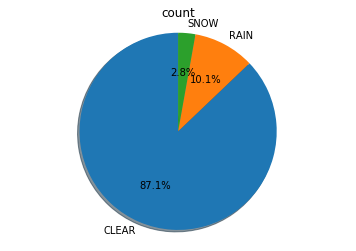

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
_.pie(autopct='%1.1f%%',
        shadow=True,startangle=90) 
plt.axis('equal')
plt.show()

In [53]:
!wc -l weather_description.csv  ## Chicago weather data

45253 weather_description.csv


In [54]:
!head weather_description.csv|csvlook

|            datetime | Chicago         |
| ------------------- | --------------- |
| 2012-10-01 12:00:00 |                 |
| 2012-10-01 13:00:00 | overcast clouds |
| 2012-10-01 14:00:00 | overcast clouds |
| 2012-10-01 15:00:00 | overcast clouds |
| 2012-10-01 16:00:00 | overcast clouds |
| 2012-10-01 17:00:00 | overcast clouds |
| 2012-10-01 18:00:00 | overcast clouds |
| 2012-10-01 19:00:00 | overcast clouds |
| 2012-10-01 20:00:00 | overcast clouds |


In [55]:
%%sql
DROP TABLE IF EXISTS weather_of_Chicago Cascade;

create table weather_of_Chicago(
    datetime timestamp,
    weather varchar(200)
)

 * postgresql://student@/dk
Done.
Done.


[]

In [56]:
%%sql
COPY weather_of_Chicago FROM '/home/ubuntu/SQL/Week12/weather_description.csv'
CSV
HEADER
;

 * postgresql://student@/dk
45253 rows affected.


[]

In [57]:
%%sql
select weather, count(weather)
from(
select * from weather_of_Chicago
where datetime between '2016-01-01' and '2017-12-31') as t
group by weather
order by count(*)

 * postgresql://student@/dk
30 rows affected.


weather,count
thunderstorm with drizzle,1
smoke,1
thunderstorm with light drizzle,1
very heavy rain,2
dust,2
heavy snow,2
proximity shower rain,2
proximity thunderstorm with drizzle,2
heavy intensity drizzle,5
proximity thunderstorm with rain,9


In [58]:
%%sql
(select sum(count)
from(
select weather, count(weather)
from(
select * from weather_of_Chicago
where datetime between '2016-01-01' and '2017-12-31') as t
group by weather
order by count(*)) as t
where weather like '%snow')
union
(
select sum(count)
from(
select weather, count(weather)
from(
select * from weather_of_Chicago
where datetime between '2016-01-01' and '2017-12-31') as t
group by weather
order by count(*)) as t
where weather like '%clear') 
union
(select sum(count)
from(
select weather, count(weather)
from(
select * from weather_of_Chicago
where datetime between '2016-01-01' and '2017-12-31') as t
group by weather
order by count(*)) as t
where weather like '%rain')

 * postgresql://student@/dk
3 rows affected.


sum
1837
4180
433


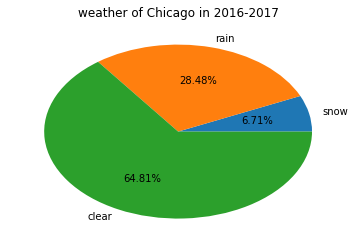

In [59]:
import numpy as np  
import matplotlib.mlab as mlab  
import matplotlib.pyplot as plt  
labels=['snow','rain','clear']
X=[433,1837,4180]  
 
fig = plt.figure()
plt.pie(X,labels=labels,autopct='%1.2f%%') 
plt.title("weather of Chicago in 2016-2017") 
plt.show() 

In [60]:
#snow and rain lead to less visibility but the number of days with snow and rain are also lesser so we cannot clearly state the reason about the accidents.

In [61]:
#the above graph as a bar chart

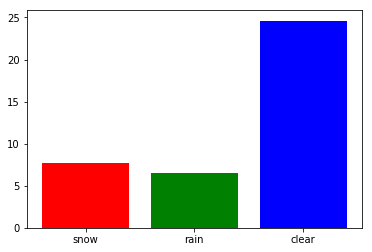

In [62]:

import matplotlib.pyplot as plt
 
name_list = ['snow','rain','clear']
num_list = [3323/433,11879/1837,102893/4180]  
plt.bar(range(len(num_list)), num_list,color='rgb',tick_label=name_list)
plt.show()


In [63]:
%%sql
select weather_condition,count 
from(
select weather_condition,count(*)
from(
select *
from(
select accidents.*,crash_date,weather_condition
from accidents,day,weather
where day.key=accidents.day_key and weather.key=accidents.weather_key) as t
where crash_date between '2016-01-01' and '2017-12-31') as t1
group by weather_condition) as t2
where weather_condition='SNOW' or weather_condition='RAIN'
or weather_condition='CLEAR'

 * postgresql://student@/dk
3 rows affected.


weather_condition,count
CLEAR,102893
RAIN,11879
SNOW,3323


In [64]:
#we have hourly data so this is an hourly condition, we are analysing at an hourly condition.

In [65]:
#This figure shows the rate: number of carsh occurred in per hour in different weather conditions. The result shows that in clear day, there is the largest number of crash happened in one hour. Then is snow and the last is rain. 
#But why? first we separated weather into clear weather and bad weather. During clear weather, there are more cars on street and drivers will be less alert. So there will be more crash in clear weather than in bad weather. 
#We have significantly less rain and snow days but still many crashes in terms of proportion
#Then for the bad weather i.e., snow and rain days are both belong to bad weather and why crash rate in snow days is larger than in rain days? In my opinion, during snow days, road conditions will be worse, driver visibility is low, and smooth roads can make it difficult to control the vehicle, resulting in more accidents per hour

In [66]:
#if we talk about the proportions we can see that for such few hours where it snows/rains there are more frequent accidents.

### Additional Analysis Using the Data Set

##### Top 5 Primary_Contributory_Cause for Each Weather

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
%%sql
select weather_condition,prim_contributory_cause,count from(
select * from(
select weather_condition,prim_contributory_cause,count(*), sum(count(*)) over (Partition BY n.weather_condition) as total, rank()
over(Partition BY n.weather_condition ORDER BY count(*) DESC) as rank
from(
select accidents.*, crash_dump.*,weather.*
from accidents, crash_dump,weather
where crash_dump.key=accidents.crash_dump_key and weather.key=accidents.weather_key) as n
group by n.weather_condition,n.prim_contributory_cause
) as m
where rank<6
order by total desc, rank asc
)
as l;

 * postgresql://student@/dk
56 rows affected.


weather_condition,prim_contributory_cause,count
CLEAR,UNABLE TO DETERMINE,102314
CLEAR,FAILING TO YIELD RIGHT-OF-WAY,33162
CLEAR,FOLLOWING TOO CLOSELY,33006
CLEAR,NOT APPLICABLE,15590
CLEAR,IMPROPER OVERTAKING/PASSING,14828
RAIN,UNABLE TO DETERMINE,10667
RAIN,FOLLOWING TOO CLOSELY,4178
RAIN,FAILING TO YIELD RIGHT-OF-WAY,4152
RAIN,WEATHER,2180
RAIN,FAILING TO REDUCE SPEED TO AVOID CRASH,1711


Observation:
1.FOLLOWING TOO CLOSELY and FAILING TO YIELD RIGHT-OF-WAY are both prevalent in all kinds of weathers. 
2.In harsh weather, WEATHER is often the main cause and ranks high in all the causes.

##### Top 5 Primary_Contributory_Cause for Three Levels of Damage

In [69]:
%%sql
select * from(
select damage,prim_contributory_cause,count(*), rank()
over(Partition BY n.damage ORDER BY count(*) DESC) as rank
from(
select accidents.*, crash_dump.*
from accidents, crash_dump
where crash_dump.key=accidents.crash_dump_key and (prim_contributory_cause!='UNABLE TO DETERMINE') and (prim_contributory_cause!='NOT APPLICABLE')
) as n
group by n.damage,n.prim_contributory_cause
) as m
where rank<6;

 * postgresql://student@/dk
15 rows affected.


damage,prim_contributory_cause,count,rank
500,FOLLOWING TOO CLOSELY,5505,1
500,FAILING TO YIELD RIGHT-OF-WAY,4985,2
500,IMPROPER BACKING,3093,3
500,IMPROPER OVERTAKING/PASSING,2655,4
500,IMPROPER LANE USAGE,1821,5
1000,FOLLOWING TOO CLOSELY,13419,1
1000,FAILING TO YIELD RIGHT-OF-WAY,10472,2
1000,IMPROPER BACKING,6039,3
1000,IMPROPER OVERTAKING/PASSING,5960,4
1000,IMPROPER LANE USAGE,4508,5


Observation:1.FAILING TO YIELD RIGHT-OF-WAY overtakes FOLLOWING TOO CLOSELY as the number 1 cause in damages over 1500 category. 2. FAILING TO REDUCE SPEED TO AVOID CRASH is unique to the damages over 1500 category which means this cause usually is very detrimental.

#####  Top 10 Average Damage Primary_Contributory_Cause

In [70]:
%%sql
select prim_contributory_cause,average from(
select prim_contributory_cause,avg(damage) as average,count(*)
from(
select CASE
      WHEN prim_contributory_cause='UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)' THEN
         'UNDER THE INFLUENCE OF ALCOHOL/DRUGS'
      ELSE
         prim_contributory_cause
      End as prim_contributory_cause
    ,damage,key,crash_dump_key
from accidents, crash_dump
where crash_dump.key=accidents.crash_dump_key and (prim_contributory_cause!='UNABLE TO DETERMINE') and (prim_contributory_cause!='NOT APPLICABLE')
) as n
group by n.prim_contributory_cause
having count(*)>100
ORDER BY avg(damage) DESC

) as m
limit 10;

 * postgresql://student@/dk
10 rows affected.


prim_contributory_cause,average
UNDER THE INFLUENCE OF ALCOHOL/DRUGS,1367.7309007981755986
DISREGARDING TRAFFIC SIGNALS,1365.3551354113438937
EXCEEDING SAFE SPEED FOR CONDITIONS,1356.7181926278240190
EXCEEDING AUTHORIZED SPEED LIMIT,1345.5098934550989346
DISREGARDING STOP SIGN,1340.3183023872679045
PHYSICAL CONDITION OF DRIVER,1329.0194126431060229
EQUIPMENT - VEHICLE CONDITION,1317.3307729236677868
DISREGARDING OTHER TRAFFIC SIGNS,1312.0759837177747626
DRIVING ON WRONG SIDE/WRONG WAY,1293.8511326860841424
FAILING TO REDUCE SPEED TO AVOID CRASH,1289.8585226499795946


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

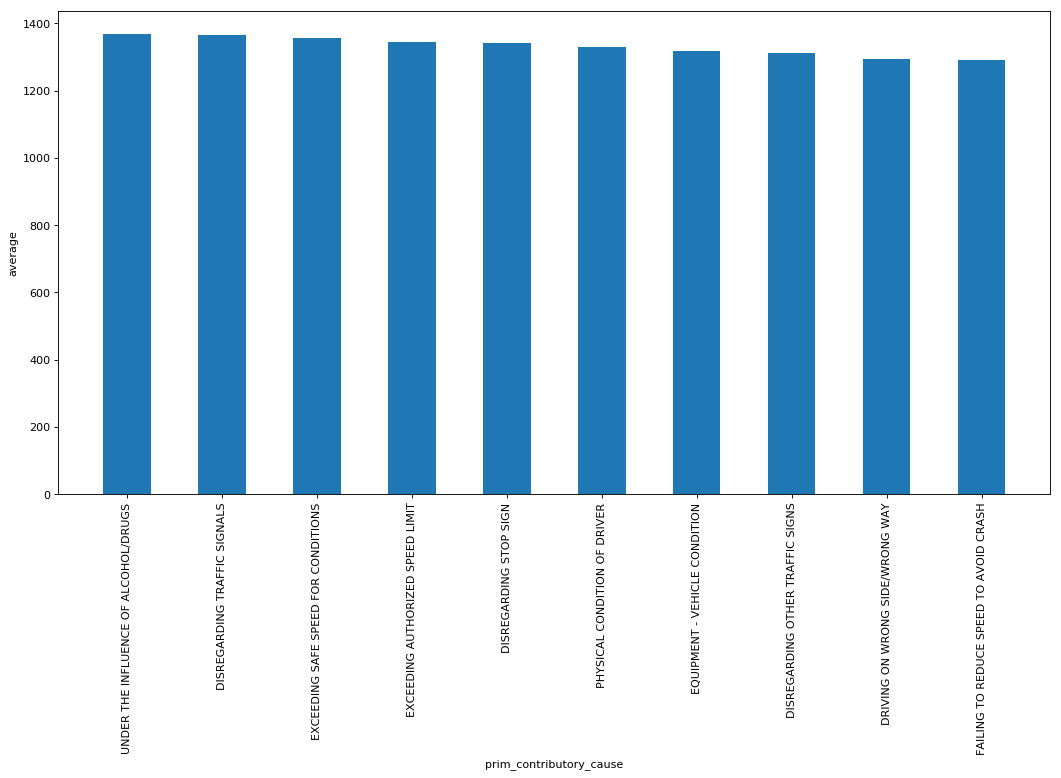

In [71]:
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')

_.bar(width=0.5)
plt.xticks(rotation='vertical')


Observation:1.The top nine causes in this graph is not present in the previous two ranking tables which means these causes happen rarely but are more dangerous if they happen. 2.Most of the causes may indicate deliberation of ignoring the regulation rather than carelessness or distraction.

##### Top 10 Primary_Contributory_Cause for HIT_AND_RUN_I

In [72]:


%%sql
select * from(
select HitandRun, prim_contributory_cause,count(*), rank()
over(Partition BY n.HitandRun ORDER BY count(*) DESC) as rank
from(
select CASE
      WHEN HIT_AND_RUN_I='' THEN
         'N'
      ELSE
         HIT_AND_RUN_I
      END AS HitandRun,prim_contributory_cause,crash_dump_key,key
from accidents, crash_dump
where crash_dump.key=accidents.crash_dump_key  and (prim_contributory_cause!='UNABLE TO DETERMINE') and (prim_contributory_cause!='NOT APPLICABLE')
) as n
group by n.HitandRun,n.prim_contributory_cause
) as m
where rank<11;


 * postgresql://student@/dk
20 rows affected.


hitandrun,prim_contributory_cause,count,rank
N,FAILING TO YIELD RIGHT-OF-WAY,34921,1
N,FOLLOWING TOO CLOSELY,33484,2
N,IMPROPER BACKING,12927,3
N,IMPROPER OVERTAKING/PASSING,12430,4
N,FAILING TO REDUCE SPEED TO AVOID CRASH,11575,5
N,IMPROPER LANE USAGE,11236,6
N,IMPROPER TURNING/NO SIGNAL,10198,7
N,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,9261,8
N,WEATHER,5405,9
N,DISREGARDING TRAFFIC SIGNALS,4486,10


Observation:1.The top six causes for two partitions are exactly the same, which indicates whether hit and run happens may not be related to the causes. 2.The "OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER" is unique to the group who hit and run and that may suggests such behaviour is related to a person's driving behaviour or personality.

##### Top 10 Primary_Contributory_Cause by Time

In [73]:


%%sql
Create or replace view period as 
select * from(
select time,prim_contributory_cause,count(*), COUNT(*) / SUM(count(*))
over(Partition BY n.time) as percent,rank() over (Partition BY n.time order by count(*) desc) as rank
from(
    
    
select CASE
      WHEN crash_hour in ('6','7','8','9','10','11') THEN
         'Morning'
    WHEN crash_hour in ('12','13','14','15','16') THEN
         'Afternoon'
    WHEN crash_hour in ('17','18','19','20','21') THEN
         'Evening'
      ELSE
         'Night'
      END AS time,prim_contributory_cause,crash_dump_key,crash_dump.key,day.key
from accidents, crash_dump,day
where crash_dump.key=accidents.crash_dump_key and day.key=day_key
    and (prim_contributory_cause!='UNABLE TO DETERMINE') and (prim_contributory_cause!='NOT APPLICABLE')
) as n
    
group by n.time,prim_contributory_cause

) as m
where rank<11

 * postgresql://student@/dk
Done.


[]

In [74]:
%%sql
select * from period limit 20;

 * postgresql://student@/dk
20 rows affected.


time,prim_contributory_cause,count,percent,rank
Afternoon,FAILING TO YIELD RIGHT-OF-WAY,15265,0.21215827438117607816,1
Afternoon,FOLLOWING TOO CLOSELY,14916,0.20730775110839321205,2
Afternoon,IMPROPER OVERTAKING/PASSING,6426,0.08931078094814526553,3
Afternoon,IMPROPER BACKING,6370,0.08853247348890216953,4
Afternoon,IMPROPER LANE USAGE,4843,0.06730969687704131979,5
Afternoon,FAILING TO REDUCE SPEED TO AVOID CRASH,4435,0.06163917110255590610,6
Afternoon,IMPROPER TURNING/NO SIGNAL,4162,0.05784492223874581312,7
Afternoon,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,4024,0.05592695028561104085,8
Afternoon,DISREGARDING TRAFFIC SIGNALS,1503,0.02088921627218523718,9
Afternoon,WEATHER,1465,0.02036107906769885061,10


In [75]:
%%sql
select prim_contributory_cause,percent from period
where time='Morning'
order by percent desc
limit 10

 * postgresql://student@/dk
10 rows affected.


prim_contributory_cause,percent
FAILING TO YIELD RIGHT-OF-WAY,0.20014620380129883377
FOLLOWING TOO CLOSELY,0.19360103362687429873
IMPROPER OVERTAKING/PASSING,0.08432219237700180205
IMPROPER BACKING,0.07558396518309476046
IMPROPER LANE USAGE,0.07288089490326748495
FAILING TO REDUCE SPEED TO AVOID CRASH,0.05894053245384379994
IMPROPER TURNING/NO SIGNAL,0.05882152935976335385
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,0.05802250858522321580
WEATHER,0.03559892557206487369
DISREGARDING TRAFFIC SIGNALS,0.02626568290775560165


Text(0.5,1,'Morning')

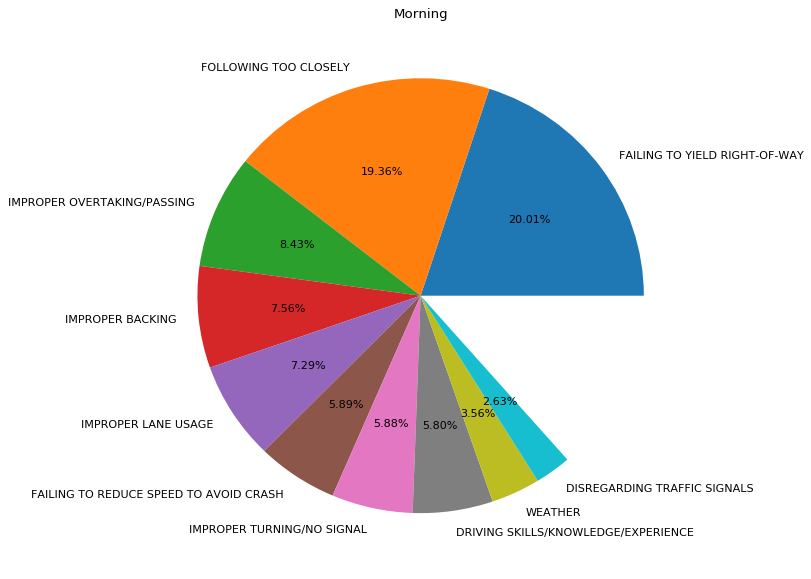

In [76]:
fig=plt.figure(figsize=(9, 9), dpi= 80, facecolor='w', edgecolor='k')
_.pie(autopct='%.2f%%')
plt.title("Morning")

In [77]:
%%sql
select prim_contributory_cause,percent from period
where time='Afternoon'
order by percent desc
limit 10


 * postgresql://student@/dk
10 rows affected.


prim_contributory_cause,percent
FAILING TO YIELD RIGHT-OF-WAY,0.21215827438117607816
FOLLOWING TOO CLOSELY,0.20730775110839321205
IMPROPER OVERTAKING/PASSING,0.08931078094814526553
IMPROPER BACKING,0.08853247348890216953
IMPROPER LANE USAGE,0.06730969687704131979
FAILING TO REDUCE SPEED TO AVOID CRASH,0.06163917110255590610
IMPROPER TURNING/NO SIGNAL,0.05784492223874581312
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,0.05592695028561104085
DISREGARDING TRAFFIC SIGNALS,0.02088921627218523718
WEATHER,0.02036107906769885061


Text(0.5,1,'Afternoon')

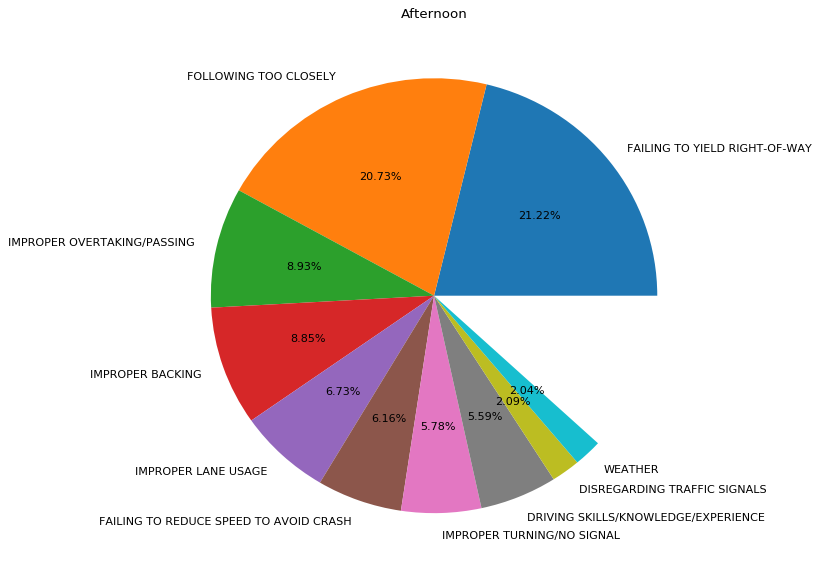

In [78]:
fig=plt.figure(figsize=(9, 9), dpi= 80, facecolor='w', edgecolor='k')
_.pie(autopct='%.2f%%')
plt.title("Afternoon")

In [79]:
%%sql
select prim_contributory_cause,percent from period
where time='Evening'
order by percent desc
limit 10


 * postgresql://student@/dk
10 rows affected.


prim_contributory_cause,percent
FOLLOWING TOO CLOSELY,0.19994397235969745074
FAILING TO YIELD RIGHT-OF-WAY,0.19633952750023344850
IMPROPER OVERTAKING/PASSING,0.08603977962461480997
IMPROPER BACKING,0.07509571388551685498
FAILING TO REDUCE SPEED TO AVOID CRASH,0.07244373891119619012
IMPROPER LANE USAGE,0.07052012326080866561
IMPROPER TURNING/NO SIGNAL,0.05959473340181156037
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,0.04887477822392380241
WEATHER,0.02422261649080212905
DISREGARDING TRAFFIC SIGNALS,0.02396115416939023251


Text(0.5,1,'Evening')

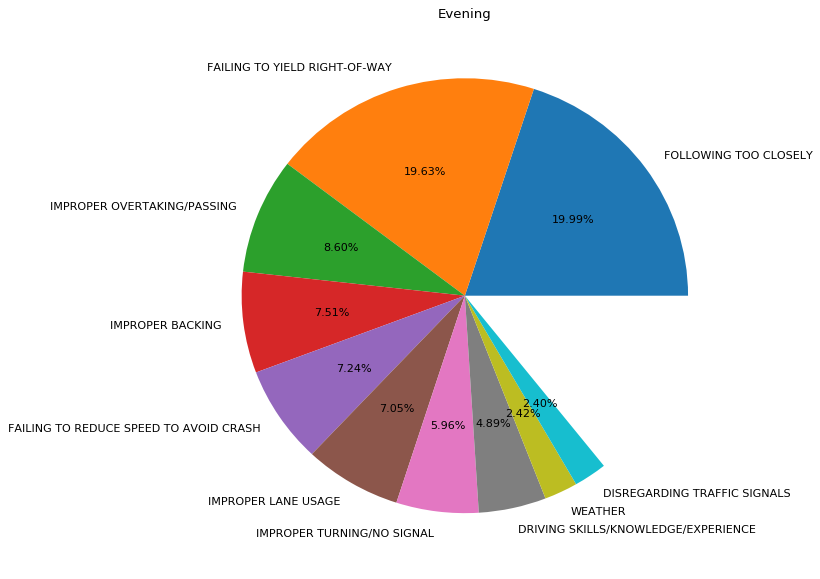

In [80]:

fig=plt.figure(figsize=(9, 9), dpi= 80, facecolor='w', edgecolor='k')
_.pie(autopct='%.2f%%')
plt.title("Evening")

In [81]:
%%sql
select prim_contributory_cause,percent from period
where time='Night'
order by percent desc
limit 10


 * postgresql://student@/dk
10 rows affected.


prim_contributory_cause,percent
FOLLOWING TOO CLOSELY,0.13133557961144168041
FAILING TO YIELD RIGHT-OF-WAY,0.11413004516452792315
FAILING TO REDUCE SPEED TO AVOID CRASH,0.10470284608215642698
IMPROPER LANE USAGE,0.06663560111835973905
IMPROPER BACKING,0.06229837264320022941
IMPROPER OVERTAKING/PASSING,0.06086457810595741630
DISREGARDING TRAFFIC SIGNALS,0.05520108968384830454
IMPROPER TURNING/NO SIGNAL,0.05408989891748512438
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,0.04667001218725356656
"""OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER""",0.03978779840848806366


Text(0.5,1,'Night')

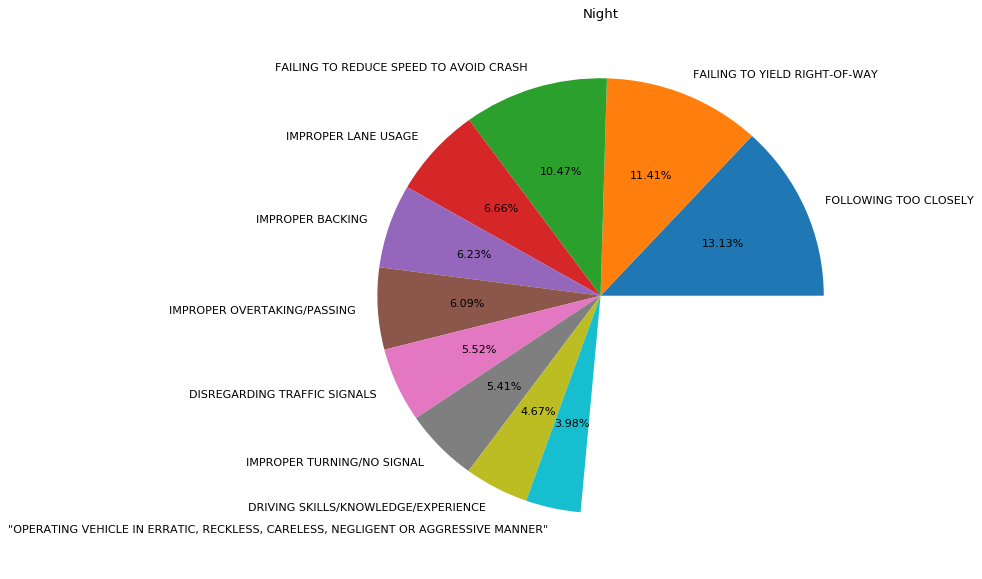

In [82]:

fig=plt.figure(figsize=(9, 9), dpi= 80, facecolor='w', edgecolor='k')
_.pie(autopct='%.2f%%')
plt.title("Night")

In [ ]:
#Observation:1.Of the four main pie charts, Morning, Afternoon and Evening have almost identical components and percentages, which means the traffic conditions during these times are similar.  
#2.The Night pie chart is significantly different with the previous three charts as the top 10 causes make up for less than 75% of the whole graph, the top two causes' shares reduce sharply, maybe due to significantly less cars on the road. 
#3. The Night chart may indicate that during the period, traffic accidents's causes are more diversified and requires special attention.